In [1]:
import os
import glob
import pickle
import re
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from acea.model_evaluation import evaluation_metrics, model_evaluation_plots
from acea.models import BaseModel
from acea.report import create_latex_score_summary
from acea.data_loaders import get_batch
from acea.model_training import batch_training

%matplotlib inline

In [2]:
FORECAST_PERIOD = 60
TEST_PERIOD = 30
TRAIN_PERIOD = 730

In [3]:
def load_data(files):
    
    # initiate dict to store data
    dfs = {}

    for f in files:

        # get name of the water body from the filename
        database = f.split('\\')[-1].replace('.csv','')
    
        # load the data
        df = pd.read_csv(f)

        # get start and end data of the data
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])

        # store data in dictionary by water body name
        dfs[database] = df
    
    return dfs

In [4]:
def get_batch(df):
    # note: forecast horizon is taken into account in feature engineering: features are  moved backwards with 
    # forecast_period!
    n = int(np.floor((len(df) - TRAIN_PERIOD - FORECAST_PERIOD)/TEST_PERIOD))
    for i in range(n):
        train_start = i*TEST_PERIOD
        train_end   = train_start + TRAIN_PERIOD
        test_end  = train_end + TEST_PERIOD
        yield list(range(train_start, train_end)), list(range(train_end, test_end)) 
        
def get_custom_batch(df, train_period, test_period):
    n = int(np.floor((len(df)-train_period- FORECAST_PERIOD)/test_period))
    for i in range(n):
        train_start = i*test_period
        train_end   = train_start + train_period
        test_end  = train_end + test_period
        yield list(range(train_start, train_end)), list(range(train_end, test_end)) 


In [5]:


def get_list_of_files(dfbest):
    best_data = []

    for i, row in dfbest.iterrows():

        method = row['method']
        name = row['name']
        if method == 'manual':
            tmp_path = os.path.join(datadir, 'feats', 'D%d'%FORECAST_PERIOD, method) 
        else:
            tmp_path = os.path.join(datadir, 'feats', 'D%d'%FORECAST_PERIOD, 'automatic', method) 

        filename = os.path.join(tmp_path, '%s.csv'%name)

        #best_data[name] = filename
        best_data.append(filename)
    return best_data

In [6]:
def get_time_diff(t0, t1):
    
    hours = int(np.floor((t1-t0)/3600))
    minutes = int(np.floor(((t1-t0) - hours*3600)/60))
    seconds = int((t1-t0) - hours*3600 - minutes*60)
    
    timing = '%2d:%2d:%2d'%(hours, minutes, seconds)
    timing = timing.replace(' ', '0')
    
    return timing
    
    
    

In [48]:
def create_best_params_overview(best_params, dfbest, which='gradientboosting'):
    
    names = best_params.keys()
    
    tmp = []
    tmp_names = []
    tmp_method = []
    for i, name in enumerate(names):
        if np.any([which in k for k in best_params[name].keys()]):
            tmp.append(best_params[name])
            tmp_names.append(name)
            tmp_method.append(dfbest.set_index('name').loc[name, 'method'])
            
    dfres = pd.DataFrame().from_records(tmp)
    dfres = dfres.rename(columns=lambda x: x.split('__')[-1]).replace(np.nan, '')

    dfres['Water body'] = [' '.join(n.split('_')[:2]) for n in tmp_names]
    dfres['Target'] = [' '.join(n.split('_')[2:]) for n in tmp_names]

    dfres['Features'] = tmp_method

    cols = ['Water body', 'Target', 'Features']
    cols = cols + list(set(dfres.columns) - set(cols))
    
    return dfres[cols]

In [47]:
dfbest

,metric,reg_name,mean,std,method,name
0,rmse,GradientBoosting,0.299532,0.503909,pearson,Aquifer_Auser_Depth_to_Groundwater_COS
1,rmse,NeuralNetwork,0.023764,0.024779,phik,Aquifer_Auser_Depth_to_Groundwater_LT2
2,rmse,SVM,0.113858,0.217154,phik,Aquifer_Auser_Depth_to_Groundwater_SAL
3,rmse,SVM,0.398188,0.279222,phik,Aquifer_Petrignano_Depth_to_Groundwater_P24
4,rmse,SVM,0.251103,0.232212,phik,Aquifer_Petrignano_Depth_to_Groundwater_P25
5,rmse,GradientBoosting,13.321826,28.586494,pearson,Lake_Bilancino_Flow_Rate
6,rmse,SVM,0.920202,1.077469,phik,Lake_Bilancino_Lake_Level
7,rmse,SVM,0.299538,0.374103,manual,River_Arno_Hydrometry_Nave_di_Rosano


# Settings

In [8]:
model_sel_metric = 'rmse'

datadir = '../data'

filename_model_features = 'results/D%s_best_models_and_features_%s.csv'%(FORECAST_PERIOD, model_sel_metric)

# Load data

### Best features

In [9]:
dfbest = pd.read_csv(filename_model_features)

files = get_list_of_files(dfbest)
dfs = load_data(files)

names = list(dfs.keys())
names

['Aquifer_Auser_Depth_to_Groundwater_COS',
 'Aquifer_Auser_Depth_to_Groundwater_LT2',
 'Aquifer_Auser_Depth_to_Groundwater_SAL',
 'Aquifer_Petrignano_Depth_to_Groundwater_P24',
 'Aquifer_Petrignano_Depth_to_Groundwater_P25',
 'Lake_Bilancino_Flow_Rate',
 'Lake_Bilancino_Lake_Level',
 'River_Arno_Hydrometry_Nave_di_Rosano']

### For base model

In [10]:
filesb = glob.glob(os.path.join(datadir, 'feats','D%d'%FORECAST_PERIOD, 'base', '*csv'))
dfsb = load_data(filesb)

# Model settings

In [11]:
reg_names = ['NeuralNetwork', 
             'SVM', 
             'GradientBoosting' 
             ]

regressors = {'NeuralNetwork': MLPRegressor(),
              'SVM': SVR(),
              'GradientBoosting': GradientBoostingRegressor(criterion='mse')
             }

params_nn = {'mlpregressor__hidden_layer_sizes' : [(100,), (200, 100)],
             'mlpregressor__solver': ['sgd','adam'],
             'mlpregressor__learning_rate': ['constant'],
             'mlpregressor__learning_rate_init': [0.001, 0.0001],
             'mlpregressor__max_iter': [400, 800],
             'mlpregressor__early_stopping': [True]}


params_gb = {'gradientboostingregressor__loss': ['ls', 'huber', 'lad'],
             'gradientboostingregressor__n_estimators': [100, 200, 300],
             'gradientboostingregressor__learning_rate': [0.1, 0.05]}

params_svr = {'svr__kernel': ['linear', 'poly', 'rbf','sigmoid'],
              'svr__C': [0.1, 1, 10]}

params = {'NeuralNetwork': params_nn,
          'SVM': params_svr,
          'GradientBoosting': params_gb}

In [12]:
dfbest

,metric,reg_name,mean,std,method,name
0,rmse,GradientBoosting,0.299532,0.503909,pearson,Aquifer_Auser_Depth_to_Groundwater_COS
1,rmse,NeuralNetwork,0.023764,0.024779,phik,Aquifer_Auser_Depth_to_Groundwater_LT2
2,rmse,SVM,0.113858,0.217154,phik,Aquifer_Auser_Depth_to_Groundwater_SAL
3,rmse,SVM,0.398188,0.279222,phik,Aquifer_Petrignano_Depth_to_Groundwater_P24
4,rmse,SVM,0.251103,0.232212,phik,Aquifer_Petrignano_Depth_to_Groundwater_P25
5,rmse,GradientBoosting,13.321826,28.586494,pearson,Lake_Bilancino_Flow_Rate
6,rmse,SVM,0.920202,1.077469,phik,Lake_Bilancino_Lake_Level
7,rmse,SVM,0.299538,0.374103,manual,River_Arno_Hydrometry_Nave_di_Rosano


In [14]:

best_params = {}
for name in names:
    
    print('#'*30, name)
    
    # get data
    df = dfs[name].copy()
    
    # llimit the data to somewhat recent years
    if 'Date' in df.columns:
        df = df[df['Date']>='2015-01-01']
    else:
        df = df.loc['2015-01-01':]

    batches = get_batch(df)
    y = df.drop(columns='Date').iloc[:,[0]].values.ravel()
    X = df.drop(columns='Date').iloc[:,1:].values

    # get model type
    reg_name = dfbest.set_index('name').loc[name, 'reg_name']
    
    # set regressor and param grid
    regressor = make_pipeline(MinMaxScaler(), regressors[reg_name])
    param = params[reg_name]

    # define model and fit
    model = GridSearchCV(regressor, param, cv=batches, n_jobs=4)
    
    # fit the model
    t0 = time.time()
    model.fit(X, y)
    print('fitting time:', get_time_diff(t0, time.time()))
    
    # save best model parameters
    best_params[name] = model.best_params_
    
    

############################## Aquifer_Auser_Depth_to_Groundwater_COS
fitting time: 00:01:19
############################## Aquifer_Auser_Depth_to_Groundwater_LT2


c:\users\ui914009\documents\code\udacity\mlengineer\capstone_project\acea\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


fitting time: 00:05:06
############################## Aquifer_Auser_Depth_to_Groundwater_SAL
fitting time: 00:00:18
############################## Aquifer_Petrignano_Depth_to_Groundwater_P24
fitting time: 00:00:04
############################## Aquifer_Petrignano_Depth_to_Groundwater_P25
fitting time: 00:00:03
############################## Lake_Bilancino_Flow_Rate
fitting time: 00:00:30
############################## Lake_Bilancino_Lake_Level
fitting time: 00:00:03
############################## River_Arno_Hydrometry_Nave_di_Rosano
fitting time: 00:00:03


In [15]:
pickle.dump(best_params, open('../models/D%d/best_params.p'%FORECAST_PERIOD, 'wb'))

# Create overview for report

In [25]:
best_params

{'Aquifer_Auser_Depth_to_Groundwater_COS': {'gradientboostingregressor__learning_rate': 0.1,
  'gradientboostingregressor__loss': 'huber',
  'gradientboostingregressor__n_estimators': 300},
 'Aquifer_Auser_Depth_to_Groundwater_LT2': {'mlpregressor__early_stopping': True,
  'mlpregressor__hidden_layer_sizes': (200, 100),
  'mlpregressor__learning_rate': 'constant',
  'mlpregressor__learning_rate_init': 0.001,
  'mlpregressor__max_iter': 800,
  'mlpregressor__solver': 'sgd'},
 'Aquifer_Auser_Depth_to_Groundwater_SAL': {'svr__C': 1, 'svr__kernel': 'rbf'},
 'Aquifer_Petrignano_Depth_to_Groundwater_P24': {'svr__C': 0.1,
  'svr__kernel': 'rbf'},
 'Aquifer_Petrignano_Depth_to_Groundwater_P25': {'svr__C': 1,
  'svr__kernel': 'rbf'},
 'Lake_Bilancino_Flow_Rate': {'gradientboostingregressor__learning_rate': 0.05,
  'gradientboostingregressor__loss': 'lad',
  'gradientboostingregressor__n_estimators': 100},
 'Lake_Bilancino_Lake_Level': {'svr__C': 1, 'svr__kernel': 'rbf'},
 'River_Arno_Hydrometry

In [50]:
for which in ['gradientboosting', 'svr', 'mlp']:
    
    dfoverview = create_best_params_overview(best_params, dfbest, which=which)
    
    print('\n\n')
    
    print(dfoverview.to_latex(index=False))




\begin{tabular}{lllrrl}
\toprule
     Water body &                    Target & Features &  learning\_rate &  n\_estimators &   loss \\
\midrule
  Aquifer Auser &  Depth to Groundwater COS &  pearson &           0.10 &           300 &  huber \\
 Lake Bilancino &                 Flow Rate &  pearson &           0.05 &           100 &    lad \\
\bottomrule
\end{tabular}




\begin{tabular}{lllrl}
\toprule
         Water body &                     Target & Features &     C &  kernel \\
\midrule
      Aquifer Auser &   Depth to Groundwater SAL &     phik &   1.0 &     rbf \\
 Aquifer Petrignano &   Depth to Groundwater P24 &     phik &   0.1 &     rbf \\
 Aquifer Petrignano &   Depth to Groundwater P25 &     phik &   1.0 &     rbf \\
     Lake Bilancino &                 Lake Level &     phik &   1.0 &     rbf \\
         River Arno &  Hydrometry Nave di Rosano &   manual &  10.0 &  linear \\
\bottomrule
\end{tabular}




\begin{tabular}{lllllllrr}
\toprule
    Water body &              

# Train with best parameters and get evaluation metrics to compare to base

# Aquifer_Auser_Depth_to_Groundwater_COS
# Aquifer_Auser_Depth_to_Groundwater_LT2


c:\users\ui914009\documents\code\udacity\mlengineer\capstone_project\acea\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\ui914009\documents\code\udacity\mlengineer\capstone_project\acea\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Aquifer_Auser_Depth_to_Groundwater_SAL
# Aquifer_Petrignano_Depth_to_Groundwater_P24
# Aquifer_Petrignano_Depth_to_Groundwater_P25
# Lake_Bilancino_Flow_Rate
# Lake_Bilancino_Lake_Level
# River_Arno_Hydrometry_Nave_di_Rosano


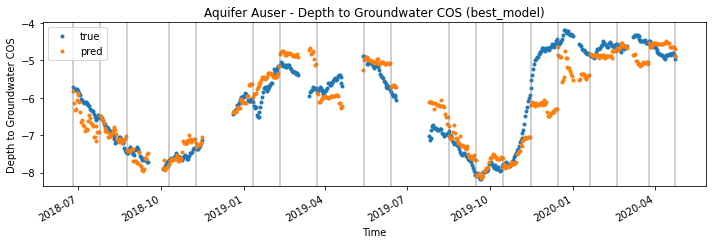

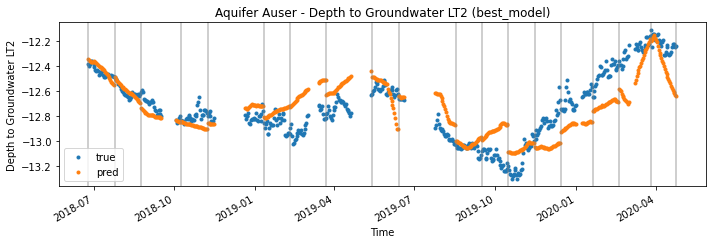

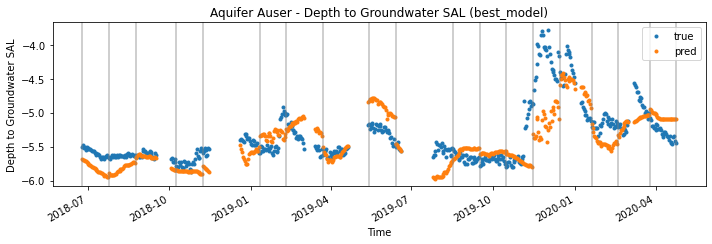

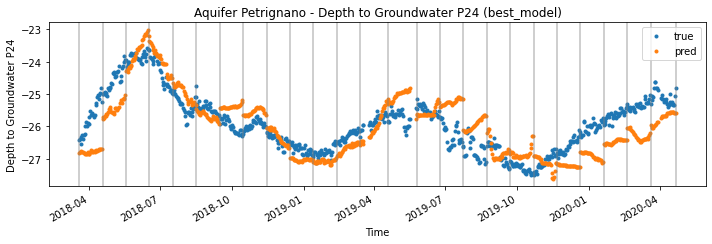

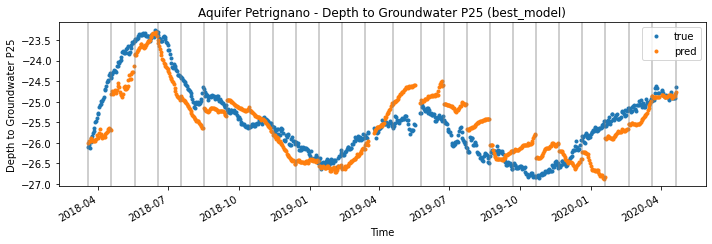

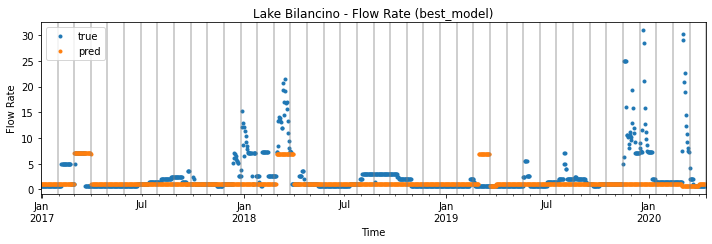

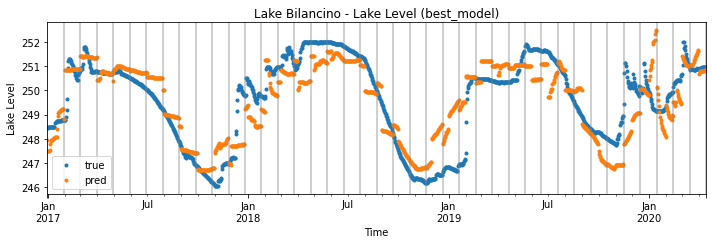

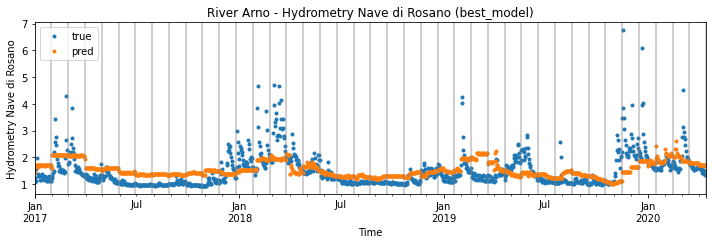

In [19]:
best_model_scores = {}

for name in names:
    
    print('#', name)
    
    params = best_params[name]
    reg_name = dfbest.set_index('name').loc[name, 'reg_name']
    
    # get data
    df = dfs[name].copy()
    
    # limit the data to somewhat recent years
    if 'Date' in df.columns:
        df = df[df['Date']>='2015-01-01']
    else:
        df = df.loc['2015-01-01':]
        
    batches = get_batch(df)
    
    y = df.drop(columns='Date').iloc[:,[0]].values
    X = df.drop(columns='Date').iloc[:,1:].values
    
    dates = df['Date'].values

    if reg_name == 'GradientBoosting':

        learning_rate = params['gradientboostingregressor__learning_rate']
        loss = params['gradientboostingregressor__loss']
        n_estimators = params['gradientboostingregressor__n_estimators']
        
        regressor = GradientBoostingRegressor(learning_rate=learning_rate, loss=loss, n_estimators=n_estimators)    
    
    elif reg_name == 'NeuralNetwork':
        
        early_stopping = params['mlpregressor__early_stopping']
        hidden_layer_sizes = params['mlpregressor__hidden_layer_sizes']
        learning_rate = params['mlpregressor__learning_rate']
        learning_rate_init = params['mlpregressor__learning_rate_init']
        max_iter = params['mlpregressor__max_iter']
        solver = params['mlpregressor__solver']
    
        regressor = MLPRegressor(learning_rate=learning_rate, learning_rate_init=learning_rate_init, 
                                    hidden_layer_sizes=hidden_layer_sizes, early_stopping=early_stopping, 
                                   max_iter=max_iter, solver=solver)
    elif reg_name == 'SVM':
        
        C = params['svr__C']
        kernel = params['svr__kernel']
        
        regressor = SVR(C=C, kernel=kernel)
        
    else:
        raise('Regressor not implemented', reg_name)
        
    scores = batch_training(X, y, dates, regressor, 'best_model', name=name)
    
    best_model_scores[name] = scores
    
    

In [20]:
best_summary = {}
for name in names:
    best_summary[name] = pd.DataFrame(best_model_scores[name]).agg(['mean', 'std']).T

In [21]:
print(create_latex_score_summary(names, best_summary))

\begin{tabular}{lllll}
\toprule
{} &                       r2 &                 rmse &                mae &               mape \\
\midrule
Aquifer\_Auser\_Depth\_to\_Groundwater\_COS      &       $ -4.01 \pm 6.39 $ &    $ 0.28 \pm 0.50 $ &  $ 0.38 \pm 0.31 $ &  $ 0.07 \pm 0.07 $ \\
Aquifer\_Auser\_Depth\_to\_Groundwater\_LT2      &       $ -6.08 \pm 5.19 $ &    $ 0.03 \pm 0.02 $ &  $ 0.14 \pm 0.08 $ &  $ 0.01 \pm 0.01 $ \\
Aquifer\_Auser\_Depth\_to\_Groundwater\_SAL      &     $ -11.46 \pm 24.06 $ &    $ 0.11 \pm 0.22 $ &  $ 0.24 \pm 0.19 $ &  $ 0.05 \pm 0.05 $ \\
Aquifer\_Petrignano\_Depth\_to\_Groundwater\_P24 &      $ -9.59 \pm 12.50 $ &    $ 0.42 \pm 0.38 $ &  $ 0.54 \pm 0.27 $ &  $ 0.02 \pm 0.01 $ \\
Aquifer\_Petrignano\_Depth\_to\_Groundwater\_P25 &     $ -11.06 \pm 12.14 $ &    $ 0.25 \pm 0.23 $ &  $ 0.41 \pm 0.22 $ &  $ 0.02 \pm 0.01 $ \\
Lake\_Bilancino\_Flow\_Rate                    &         $ -inf \pm inf $ &  $ 14.90 \pm 35.24 $ &  $ 1.77 \pm 2.46 $ &  $ 0.78 \pm 1.20 $ \\

# Train base model and get evaluation metrics

- note: time period used for training/testing/validation has changed, compared to notebook 6

# Aquifer_Auser_Depth_to_Groundwater_COS
# Aquifer_Auser_Depth_to_Groundwater_LT2
# Aquifer_Auser_Depth_to_Groundwater_SAL
# Aquifer_Petrignano_Depth_to_Groundwater_P24
# Aquifer_Petrignano_Depth_to_Groundwater_P25
# Lake_Bilancino_Flow_Rate
# Lake_Bilancino_Lake_Level
# River_Arno_Hydrometry_Nave_di_Rosano


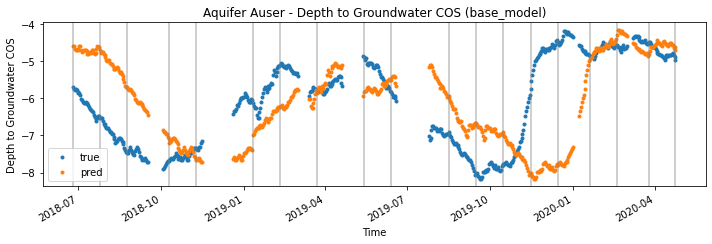

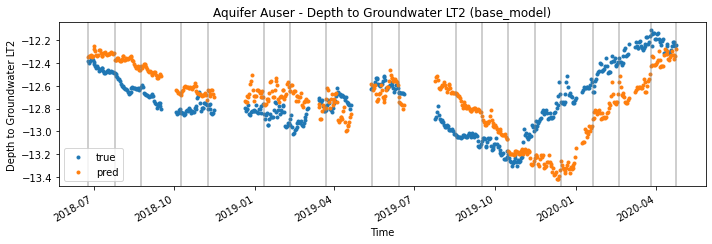

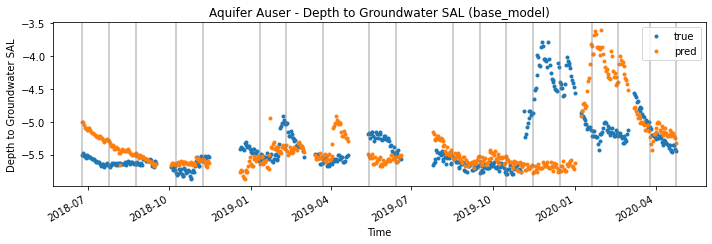

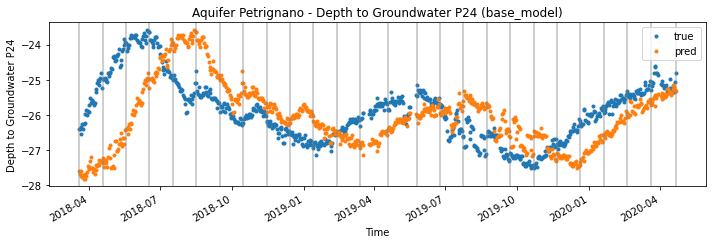

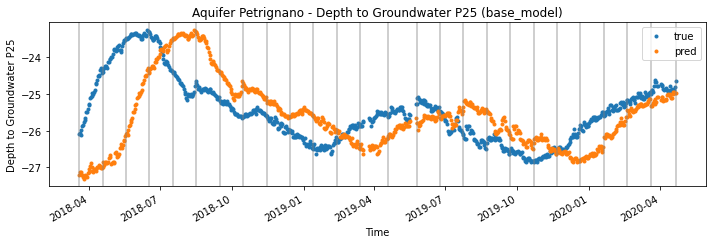

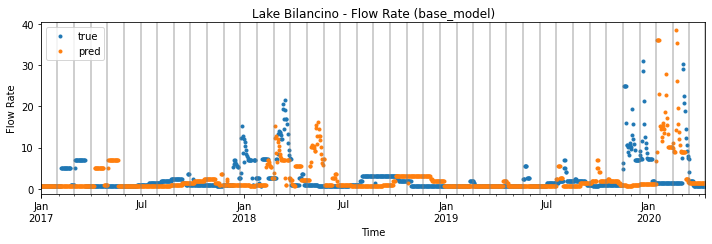

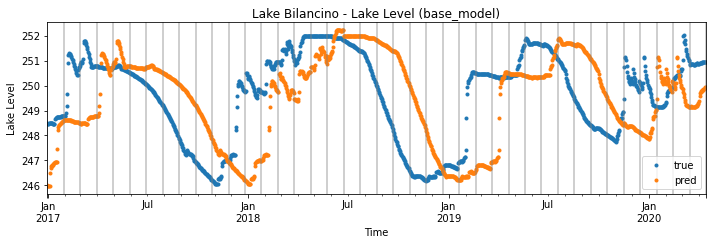

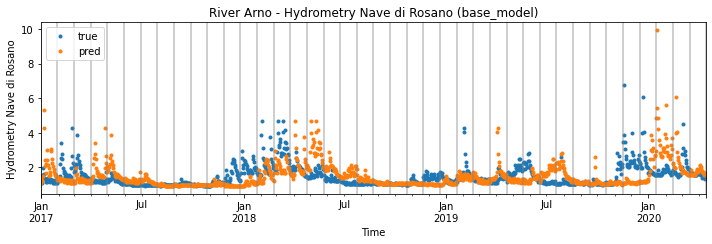

In [22]:
base_model_scores = {}

for name in names:
    
    print('#', name)
    
    # get data
    df = dfsb[name].copy()
    
    # limit the data to somewhat recent years
    if 'Date' in df.columns:
        df = df[df['Date']>='2015-01-01']
    else:
        df = df.loc['2015-01-01':]
        
    batches = get_batch(df)
    
    y = df.drop(columns='Date').iloc[:,[0]].values
    X = df.drop(columns='Date').iloc[:,1:].values
    
    dates = df['Date'].values

    regressor = BaseModel()
    
    scores = batch_training(X, y, dates, regressor, 'base_model', name=name)
    
    base_model_scores[name] = scores
    
    

In [23]:
base_summary = {}
for name in names:
    base_summary[name] = pd.DataFrame(base_model_scores[name]).agg(['mean', 'std']).T

In [24]:
print(create_latex_score_summary(names, base_summary))

\begin{tabular}{lllll}
\toprule
{} &                        r2 &                 rmse &                mae &               mape \\
\midrule
Aquifer\_Auser\_Depth\_to\_Groundwater\_COS      &      $ -30.02 \pm 43.97 $ &    $ 1.78 \pm 2.61 $ &  $ 1.01 \pm 0.80 $ &  $ 0.18 \pm 0.17 $ \\
Aquifer\_Auser\_Depth\_to\_Groundwater\_LT2      &      $ -18.34 \pm 19.13 $ &    $ 0.07 \pm 0.08 $ &  $ 0.23 \pm 0.12 $ &  $ 0.02 \pm 0.01 $ \\
Aquifer\_Auser\_Depth\_to\_Groundwater\_SAL      &      $ -24.63 \pm 45.97 $ &    $ 0.34 \pm 0.62 $ &  $ 0.38 \pm 0.40 $ &  $ 0.08 \pm 0.09 $ \\
Aquifer\_Petrignano\_Depth\_to\_Groundwater\_P24 &      $ -22.69 \pm 33.40 $ &    $ 1.05 \pm 1.46 $ &  $ 0.82 \pm 0.55 $ &  $ 0.03 \pm 0.02 $ \\
Aquifer\_Petrignano\_Depth\_to\_Groundwater\_P25 &     $ -62.19 \pm 170.06 $ &    $ 1.00 \pm 1.70 $ &  $ 0.77 \pm 0.61 $ &  $ 0.03 \pm 0.03 $ \\
Lake\_Bilancino\_Flow\_Rate                    &          $ -inf \pm inf $ &  $ 28.94 \pm 64.93 $ &  $ 2.84 \pm 3.59 $ &  $ 1.68 \pm 2.